<a href="https://colab.research.google.com/github/ActuaryJoe/joe-is-learning/blob/master/Submission_notebook_(Python).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div style="text-align: center">
  <img alt="AIcrowd" src="https://gitlab.aicrowd.com/jyotish/pricing-game-notebook-scripts/raw/master/pricing-game-banner.png">
</div>

# How to use this notebook 📝

1. **Copy the notebook**. This is a shared template and any edits you make here will not be saved. _You should copy it into your own drive folder._ For this, click the "File" menu (top-left), then "Save a Copy in Drive". You can edit your copy however you like.
2. **Link it to your AICrowd account**. In order to submit your code to AICrowd, you need to provide your account's API key (see [_"Configure static variables"_](#static-var) for details).
3. **Stick to the function definitions**. The submission to AICrowd will look for the pre-defined function names:
  - `fit_model`
  - `save_model`
  - `load_model`
  - `predict_expected_claim`
  - `predict_premium`

    Anything else you write outside of these functions will not be part of the final submission (including constants and utility functions), so make sure everything is defined within them, except for:
4. **Define your preprocessing**. In addition to the functions above, anything in the cell labelled [_"Define your data preprocessing"_](#data-preprocessing) will also be imported into your final submission. 

# Your pricing model 🕵️

In this notebook, you can play with the data, and define and train your pricing model. You can then directly submit it to the AICrowd, with some magic code at the end.

### Baseline logistic regression 💪
You can also play with a baseline logistic regression model [implemented here](https://colab.research.google.com/drive/1iDgDgWUw9QzOkbTYjeyY3i3DGuCoghs3?usp=sharing). 

# Setup the notebook 🛠

In [1]:
!bash <(curl -sL https://gitlab.aicrowd.com/jyotish/pricing-game-notebook-scripts/raw/master/python/setup.sh)
from aicrowd_helpers import *

⚙️ Installing AIcrowd utilities...
  Running command git clone -q https://gitlab.aicrowd.com/yoogottamk/aicrowd-cli /tmp/pip-req-build-heyw1_nn
✅ Installed AIcrowd utilities


# Configure static variables 📎
<a name="static-var"></a>

In order to submit using this notebook, you must visit this URL https://aicrowd.com/participants/me and copy your API key. 

Then you must set the value of `AICROWD_API_KEY` wuth the value.

In [2]:
import sklearn

class Config:
  TRAINING_DATA_PATH = 'training.csv'
  MODEL_OUTPUT_PATH = 'model.pkl'
  AICROWD_API_KEY = '0920693d39943f7576cf286a0a1cf6f1'  # You can get the key from https://aicrowd.com/participants/me
  ADDITIONAL_PACKAGES = [
    'numpy',  # you can define versions as well, numpy==0.19.2
    'pandas',
    'scikit-learn==' + sklearn.__version__,
  ]

# Download dataset files 💾

In [3]:
# Make sure to offically join the challenge and accept the challenge rules! Otherwise you will not be able to download the data
%download_aicrowd_dataset

💾 Downloading dataset...
Verifying API Key...
API Key valid
Saved API Key successfully!
✅ Downloaded dataset


# Packages 🗃

<a name="packages"></a>

Import here all the packages you need to define your model. **You will need to include all of these packages in `Config.ADDITIONAL_PACKAGES` for your code to run properly once submitted.**

In [4]:
%%track_imports

import numpy as np
import pandas as pd
import pickle

In [5]:
import importlib
import global_imports
importlib.reload(global_imports)
from global_imports import *  # do not change this

# Loading the data 📲

In [6]:
df = pd.read_csv(Config.TRAINING_DATA_PATH)
X_train = df.drop(columns=['claim_amount'])
y_train = df['claim_amount']

## How does the data look like? 🔍

In [7]:
X_train.sample(n=4)

,id_policy,year,pol_no_claims_discount,pol_coverage,pol_duration,pol_sit_duration,pol_pay_freq,pol_payd,pol_usage,drv_sex1,drv_age1,drv_age_lic1,drv_drv2,drv_sex2,drv_age2,drv_age_lic2,vh_make_model,vh_age,vh_fuel,vh_type,vh_speed,vh_value,vh_weight,population,town_surface_area
144898,PL086446,3.0,0.196,Max,3,3,Yearly,No,Retired,M,57.0,36.0,No,0,NaN,NaN,zkreetxvsoihwkgo,9.0,Diesel,Tourism,238.0,29271.0,1444.0,1520.0,112.9
43610,PL075453,1.0,0.000,Med2,23,6,Biannual,No,WorkPrivate,M,39.0,21.0,No,0,NaN,NaN,rthsjeyjgdlmkygk,21.0,Gasoline,Tourism,182.0,12820.0,1036.0,1150.0,376.5
4127,PL036830,1.0,0.381,Med2,5,3,Yearly,No,WorkPrivate,F,37.0,18.0,No,0,NaN,NaN,rrlvhbnzrdtphqnl,5.0,Gasoline,Tourism,182.0,16876.0,1302.0,2550.0,71.0
20391,PL033649,1.0,0.000,Med2,12,8,Yearly,No,WorkPrivate,M,75.0,46.0,No,0,NaN,NaN,rthsjeyjgdlmkygk,19.0,Gasoline,Tourism,182.0,12820.0,1036.0,670.0,73.8


In [8]:
y_train.sample(n=4)

130778    0.0
13161     0.0
10995     0.0
105046    0.0
Name: claim_amount, dtype: float64

In [9]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 228216 entries, 0 to 228215
Data columns (total 25 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   id_policy               228216 non-null  object 
 1   year                    228216 non-null  float64
 2   pol_no_claims_discount  228216 non-null  float64
 3   pol_coverage            228216 non-null  object 
 4   pol_duration            228216 non-null  int64  
 5   pol_sit_duration        228216 non-null  int64  
 6   pol_pay_freq            228216 non-null  object 
 7   pol_payd                228216 non-null  object 
 8   pol_usage               228216 non-null  object 
 9   drv_sex1                228216 non-null  object 
 10  drv_age1                228216 non-null  float64
 11  drv_age_lic1            228216 non-null  float64
 12  drv_drv2                228216 non-null  object 
 13  drv_sex2                228216 non-null  object 
 14  drv_age2            

In [12]:
X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
year,228216.0,2.500000,1.118036,1.0,1.75,2.5,3.25,4.0
pol_no_claims_discount,228216.0,0.044383,0.118354,0.0,0.00,0.0,0.00,1.0
pol_duration,228216.0,12.608651,8.638768,1.0,5.00,11.0,18.00,44.0
pol_sit_duration,228216.0,4.245049,2.622117,1.0,3.00,4.0,5.00,26.0
drv_age1,228216.0,56.339328,14.978742,19.0,45.00,56.0,67.00,104.0
drv_age_lic1,228216.0,34.132366,13.901112,1.0,24.00,34.0,44.00,80.0
drv_age2,75320.0,48.569888,16.338162,18.0,36.00,47.0,61.00,102.0
drv_age_lic2,75320.0,26.686564,14.943528,1.0,15.00,25.0,38.00,83.0
vh_age,228212.0,11.139774,7.135487,1.0,6.00,10.0,15.00,64.0
vh_speed,225664.0,170.946434,25.550016,95.0,155.00,174.0,183.00,251.0


In [21]:
y_train.describe()

count    228216.000000
mean        114.181250
std         725.125386
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max      141828.260000
Name: claim_amount, dtype: float64

In [48]:
loss = pd.DataFrame(y_train)
loss.head()

,claim_amount
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0


In [53]:
for i in X_train.columns:
  print(i)  

id_policy
year
pol_no_claims_discount
pol_coverage
pol_duration
pol_sit_duration
pol_pay_freq
pol_payd
pol_usage
drv_sex1
drv_age1
drv_age_lic1
drv_drv2
drv_sex2
drv_age2
drv_age_lic2
vh_make_model
vh_age
vh_fuel
vh_type
vh_speed
vh_value
vh_weight
population
town_surface_area


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


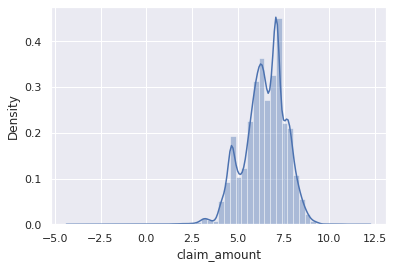

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

sns.distplot(np.log(loss.query('claim_amount>0 & claim_amount<140000')['claim_amount']))


In [56]:
# Compute skewness and kurtosis
print("Skewness: %f" % loss['claim_amount'].skew())
print("Kurtosis: %f" % loss['claim_amount'].kurt())

Skewness: 80.691243
Kurtosis: 13290.883759


# Training the model 🚀

You must first define your first function: `fit_model`. This function takes training data as arguments, and outputs a "model" object -- that you define as you wish. For instance, this could be an array of parameter values.

## Define your data preprocessing

<a name="data-preprocessing"></a>

You can add any class or function in this cell for preprocessing. Just make sure that you use the functions here in the `fit_model`, `predict_expected_claim` and `predict_premium` functions if necessary. *italicised text*

In [ ]:
%%aicrowd_include
# This magical command saves all code in this cell to a utils module.

# include your preprocessing functions and classes here. 

In [ ]:
import importlib
import utils
importlib.reload(utils)
from utils import *  # do not change this

## Define the training logic

In [ ]:
def fit_model(X_raw, y_raw):
    """Model training function: given training data (X_raw, y_raw), train this pricing model.

    Parameters
    ----------
    X_raw : Pandas dataframe, with the columns described in the data dictionary.
        Each row is a different contract. This data has not been processed.
    y_raw : a Numpy array, with the value of the claims, in the same order as contracts in X_raw.
        A one dimensional array, with values either 0 (most entries) or >0.

    Returns
    -------
    self: this instance of the fitted model. This can be anything, as long as it is compatible
        with your prediction methods.

    """

    # TODO: train your model here.
    # Don't forget any preprocessing of the raw data here

    return np.mean(y_raw)  # By default, training a model that returns a mean value (a mean model).

## Train your model

In [ ]:
trained_model = fit_model(X_train, y_train)

**Important note**: your training code should be able to run in under 10 minutes (since this notebook is re-run entirely on the server side). 

If you run into an issue here we recommend using the *zip file submission* (see the [challenge page](https://www.aicrowd.com/challenges/insurance-pricing-game/#how-to%20submit)). In short, you can simply do this by copy-pasting your `fit_model`, `predict_expected_claim` and `predict_premium` functions to the `model.py` file.

Note that if you want to perform extensive cross-validation/hyper-parameter selection, it is better to do them offline, in a separate notebook.

## Saving your model

You can save your model to a file here, so you don't need to retrain it every time.

In [ ]:
def save_model(model_path):  # some models such xgboost models or keras models don't pickle very reliably. Please use the package provided saving functions instead. 
  with open(model_path, 'wb') as target_file:
      pickle.dump(trained_model, target_file)

In [ ]:
save_model(Config.MODEL_OUTPUT_PATH)

If you need to load it from file, you can use this code:

In [ ]:
def load_model(model_path): # some models such xgboost models or keras models don't pickle very reliably. Please use the package provided saving functions instead. 
  with open(model_path, 'rb') as target:
      return pickle.load(target)

In [ ]:
trained_model = load_model(Config.MODEL_OUTPUT_PATH)

# Predicting the claims 💵

The second function, `predict_expected_claim`, takes your trained model and a dataframe of contracts, and outputs a prediction for the (expected) claim incurred by each contract. This expected claim can be seen as the probability of an accident multiplied by the cost of that accident.

This is the function used to compute the _RMSE_ leaderboard, where the model best able to predict claims wins.

In [ ]:
def predict_expected_claim(model, X_raw):
    """Model prediction function: predicts the expected claim based on the pricing model.

    This functions estimates the expected claim made by a contract (typically, as the product
    of the probability of having a claim multiplied by the expected cost of a claim if it occurs),
    for each contract in the dataset X_raw.

    This is the function used in the RMSE leaderboard, and hence the output should be as close
    as possible to the expected cost of a contract.

    Parameters
    ----------
    model: a Python object that describes your model. This can be anything, as long
        as it is consistent with what `fit` outpurs.
    X_raw : Pandas dataframe, with the columns described in the data dictionary.
        Each row is a different contract. This data has not been processed.

    Returns
    -------
    avg_claims: a one-dimensional Numpy array of the same length as X_raw, with one
        expected claim per contract (in same order). These expected claims must be POSITIVE (>0).
    """

    # TODO: estimate the expected claim of every contract.
    # Don't forget any preprocessing of the raw data here
    
    return np.full( (len(X_raw.index),), model )  # Estimate that each contract will cost 114 (this is the naive mean model). You should change this!

To test your function, run it on your training data:

In [ ]:
predict_expected_claim(trained_model, X_train)

# Pricing contracts 💰💰

The third and final function, `predict_premium`, takes your trained model and a dataframe of contracts, and outputs a _price_ for each of these contracts. **You are free to set this prices however you want!** These prices will then be used in competition with other models: contracts will choose the model offering the lowest price, and this model will have to pay the cost if an accident occurs.

This is the function used to compute the _profit_ leaderboard: your model will participate in many markets of size 10, populated by other participants' model, and we compute the average profit of your model over all the markets it participated in.

In [ ]:
def predict_premium(model, X_raw):
    """Model prediction function: predicts premiums based on the pricing model.

    This function outputs the prices that will be offered to the contracts in X_raw.
    premium will typically depend on the average claim predicted in 
    predict_average_claim, and will add some pricing strategy on top.

    This is the function used in the average profit leaderboard. Prices output here will
    be used in competition with other models, so feel free to use a pricing strategy.

    Parameters
    ----------
    model: a Python object that describes your model. This can be anything, as long
        as it is consistent with what `fit` outpurs.
    X_raw : Pandas dataframe, with the columns described in the data dictionary.
        Each row is a different contract. This data has not been processed.

    Returns
    -------
    prices: a one-dimensional Numpy array of the same length as X_raw, with one
        price per contract (in same order). These prices must be POSITIVE (>0).
    """

    # TODO: return a price for everyone.
    # Don't forget any preprocessing of the raw data here

    return predict_expected_claim(model, X_raw) * 2  # Default: bosst prices by a factor of 2

To test your function, run it on your training data.

In [ ]:
prices = predict_premium(trained_model, X_train)

#### Profit on training data

In order for your model to be considered in the profit competition, it needs to make nonnegative profit over its training set. You can check that your model satisfies this condition below:

In [ ]:
print('Income:', prices.sum())
print('Losses:', y_train.sum())

if prices.sum() < y_train.sum():
    print('Your model loses money on the training data! It does not satisfy market rule 1: Non-negative training profit.')
    print('This model will be disqualified from the weekly profit leaderboard, but can be submitted for educational purposes to the RMSE leaderboard.')
else:
    print('Your model passes the non-negative training profit test!')

# Ready? Submit to AIcrowd 🚀

If you are satisfied with your code, run the code below to send your code to the AICrowd servers for evaluation! This requires the variable `trained_model` to be defined by your previous code.

**Make sure you have included all packages needed to run your code in the [_"Packages"_](#packages) section.**

**NOTE**: If you submit the baseline RMSE model without any change whatsoever, your model will not be entered into the market. 

In [ ]:
%aicrowd_submit